# Laboratorio 10

## 1. Librerías

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from DQN import DQN
import numpy as np

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Crear entorno de CartPole

In [3]:
env = gym.make("CartPole-v1")

## 3. Definir Redes en línea y de destino

In [4]:
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

## 4. Establecer hiperparámetros

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

## 5. Defina la selección de acciones epsilon-greedy

In [8]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## 6. Defina la reproducción de la experiencia

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    def get_all(self):
        return self.memory

In [10]:
memory = ReplayMemory(10000)

## 7. Ciclo de entrenamiento

In [11]:

steps_done = 0
episode_durations = []
rewards_episode = []

In [12]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [13]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

100%|██████████| 500/500 [15:34<00:00,  1.87s/it]


Complete


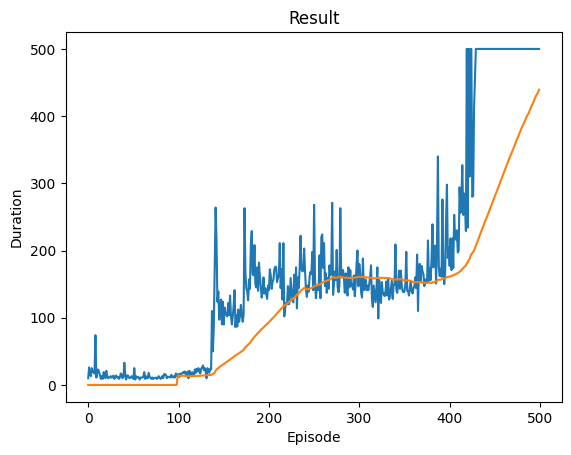

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
def train():
    if torch.cuda.is_available():
        num_episodes = 500
    else:
        num_episodes = 50

    for i_episode in tqdm(range(num_episodes)):
        sum_reward = 0
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            sum_reward += reward.cpu().numpy()[0]
            done = terminated or truncated

            if terminated:
                next_state = None
                rewards_episode.append(sum_reward)
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model()

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                break
    env.close()

train()
torch.save(policy_net.state_dict(), 'cartpole_dqn.pth')
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

## 8. Representar el entorno

In [16]:
env = gym.make("CartPole-v1", render_mode='human')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
loaded_model = DQN(n_observations, n_actions).to(device)
loaded_model.load_state_dict(torch.load('cartpole_dqn.pth'))
loaded_model.eval()  # Set the model to evaluation mode


DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

## 9. Supervisión del entrenamiento

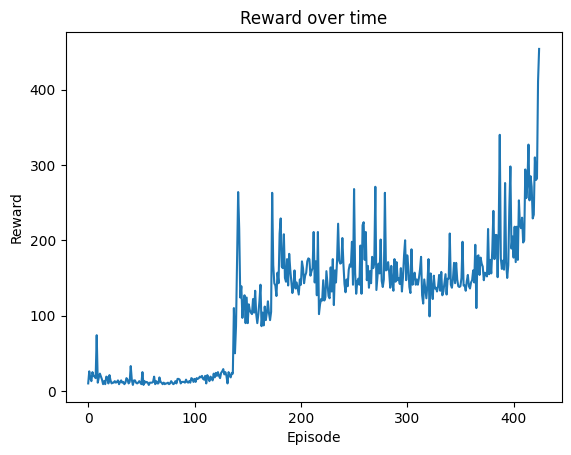

In [17]:
# Crear el gráfico
plt.plot(rewards_episode)
plt.title('Reward over time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


## 10. Evaluar el rendimiento

In [18]:
loaded_model = DQN(n_observations, n_actions).to(device)
loaded_model.load_state_dict(torch.load('cartpole_dqn.pth'))
loaded_model.eval()  # Set the model to evaluation mode

In [22]:

def evaluate_model(model, episodes=1):
    for i in range(episodes):
        tiempo = 600
        env = gym.make("CartPole-v1", render_mode='human')
        
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False
        while not done:
            with torch.no_grad():
                action = model(state).max(1)[1].view(1, 1)
            next_state, _, done, _, _ = env.step(action.item())
            env.render()  # Render the environment to visualize it
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            tiempo -= 1
            if tiempo == 0:
                print(f'Time out! Muy buen modelo no se cayó modelo')
                done = True
                
        env.close()


evaluate_model(loaded_model)

Time out! Muy buen modelo no se cayó modelo No.1
Time out! Muy buen modelo no se cayó modelo No.2
Time out! Muy buen modelo no se cayó modelo No.3
Time out! Muy buen modelo no se cayó modelo No.4
Time out! Muy buen modelo no se cayó modelo No.5
Time out! Muy buen modelo no se cayó modelo No.6
Time out! Muy buen modelo no se cayó modelo No.7
Time out! Muy buen modelo no se cayó modelo No.8


## 11. Fine-tuning

In [ ]:
BATCH_SIZE_array = [128, 256, 512]
LR = [1e-4, 1e-3, 1e-2]

result = {}

for batch_size in BATCH_SIZE_array:
    for lr in LR:
        print('Batch size: ', batch_size, 'Learning rate: ', lr)
        BATCH_SIZE = batch_size
        LR = lr
        optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
        memory = ReplayMemory(10000)
        steps_done = 0
        episode_durations = []
        rewards_episode = []
        train()
        result[(batch_size, lr)] = rewards_episode
        
        
for key in result:
    plt.plot(result[key], label=key)
    plt.legend()
        
